# Import library

In [ ]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import openmeteo_requests
import requests_cache
from retry_requests import retry
from datetime import date, datetime
from dateutil.relativedelta import *
import joblib

Read .csv file and split it to 2 np array:

date contain the date of samples

data contain the features of samples

In [ ]:
random_state = 69
data_path = "/content/drive/MyDrive/SE355/DoAn/Data/"

In [ ]:
csv_path = data_path + "dataset.csv"
df = pd.read_csv(csv_path)
df.head()
date = df.iloc[:, 0:1].to_numpy()
data = df.iloc[:, 1:-3].to_numpy().astype(np.float32)
labels = df.iloc[:, -3:].to_numpy().astype(np.int8)

# Plot label's distribution


 [0 1] [20869  3779]


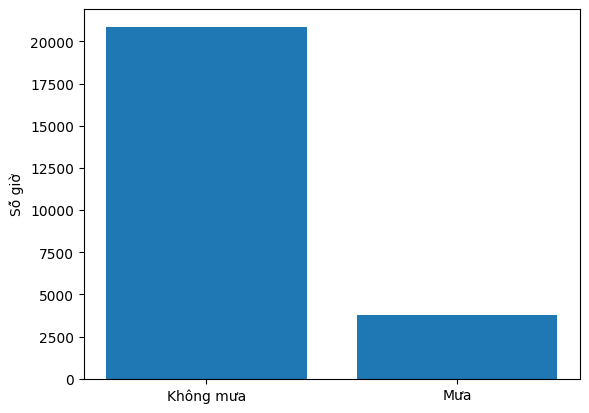


 [0 1 2] [20979  2118  1551]


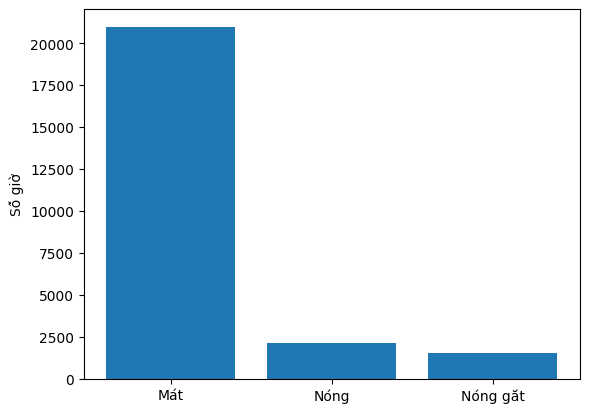


 [0 1] [16643  8005]


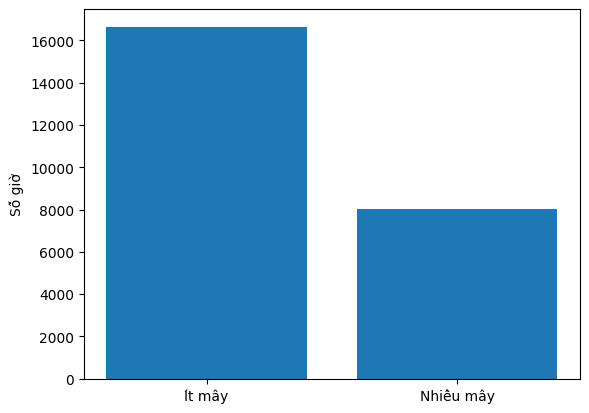

In [ ]:
def plot_labels(labels, classes):
  unique_labels, counts = np.unique(labels, return_counts=True)
  print("\n", unique_labels, counts)
  plt.bar(unique_labels, counts)
  plt.ylabel("Số giờ")
  plt.xticks(unique_labels, classes)
  plt.show()

classes = [["Không mưa", "Mưa"], ["Mát", "Nóng", "Nóng gắt"], ["Ít mây", "Nhiều mây"]]
for i in range(3):
  plot_labels(labels[:, i], classes[i])

# Standardize and PCA

In [42]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [45]:
numbers = [10, 50, 100, 200, 300, 500, 1000, 2000, 3000]
info_ratio = []
for n in numbers:
  pca = PCA(n_components=n)
  pca.fit(data_scaled)
  info_ratio.append(np.sum(pca.explained_variance_ratio_))

In [46]:
for n, ir in zip(numbers, info_ratio):
  print(n, ir)

10 0.41475385
50 0.5776121
100 0.6442518
200 0.715933
300 0.76048493
500 0.81751096
1000 0.89318186
2000 0.9616299
3000 0.9887144


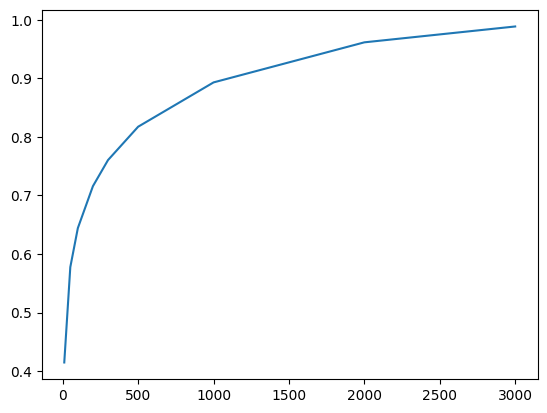

In [47]:
plt.plot(numbers, info_ratio)

In [48]:
pca = PCA(n_components=500)
data_pca = pca.fit_transform(data_scaled)

# Undersampling

In [90]:
def undersampling(labels, random_state):
  unique_labels, counts = np.unique(labels, return_counts=True)
  final_indices = []
  for la in unique_labels:
    indices = np.where(labels==la)
    np.random.seed(random_state)
    indices = np.random.choice(indices[0], size= min(counts))
    # print(indices)
    final_indices.append(indices)
  return np.concatenate(final_indices)

In [49]:
train_ids = []
test_ids = []

#labels.T to loop through each label
for label in labels.T:
  random_ids = undersampling(label, random_state)
  label_train_ids, label_test_ids = train_test_split(random_ids, train_size=0.8, random_state=random_state)
  train_ids.append(label_train_ids)
  test_ids.append(label_test_ids)

train_ids = np.unique(np.concatenate(train_ids))
test_ids = np.unique(np.concatenate(test_ids))

In [95]:
X_trains = []
Y_trains = []
for i in range(3):
  random_ids = train_ids[undersampling(labels[train_ids, i], random_state)]
  X_under, Y_under = data_pca[random_ids], labels[random_ids]
  X_trains.append(X_under)
  Y_trains.append(Y_under)

# Rain predict model

In [100]:
Y_train_rain = Y_trains[0].T[0]

In [97]:
def logistic(X_train, Y_train):
  logis = LogisticRegression()
  logis.fit(X_train, Y_train)
  train_pred = logis.predict(X_train)
  return train_pred, logis

In [101]:
rain_train_pred, rain_logis= logistic(X_trains[0], Y_train_rain)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [141]:
def cm_display(true_labels, pred_labels):
  classes = np.unique(true_labels)
  cm = confusion_matrix(true_labels, pred_labels, labels=classes)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  disp.plot()
  plt.show()

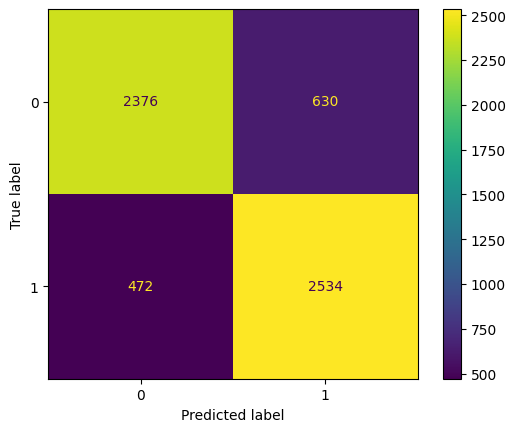

In [121]:
cm_display(Y_train_rain, rain_train_pred)

In [127]:
def svc_with_kernel(kernel, X_train, Y_train):
  svc = SVC(kernel= kernel)
  svc.fit(X_train, Y_train)
  train_pred = svc.predict(X_train)
  return train_pred, svc

In [128]:
rain_train_pred, rain_svc = svc_with_kernel("rbf", X_trains[0], Y_train_rain)

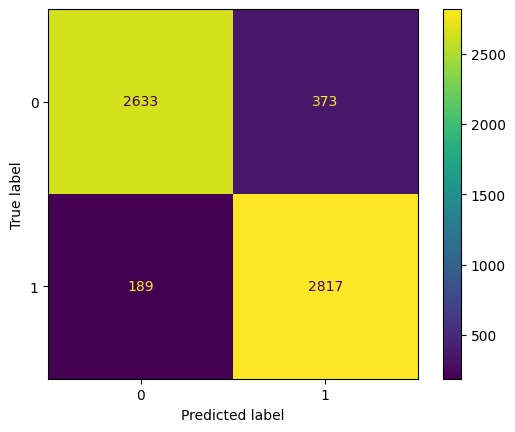

In [129]:
cm_display(Y_train_rain, rain_train_pred)

In [130]:
def random_forest(X_train, Y_train, ran_estimators, ran_depth):
  ran_forest = RandomForestClassifier(n_estimators=ran_estimators, max_depth=ran_depth, random_state=random_state)
  ran_forest.fit(X_train, Y_train)
  train_pred = ran_forest.predict(X_train)
  return train_pred, ran_forest

In [132]:
rain_train_pred, rain_rf = random_forest(X_trains[0], Y_train_rain, 200, 22)

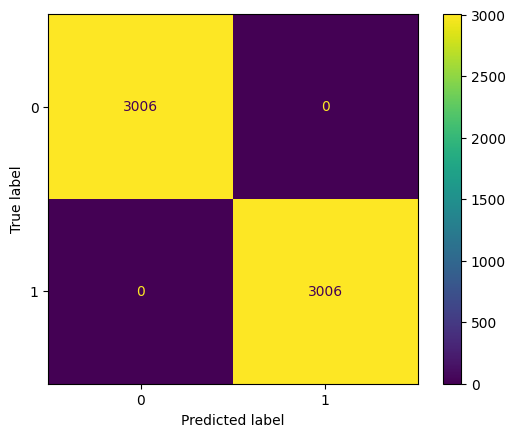

In [133]:
cm_display(Y_train_rain, rain_train_pred)

# Heat predict model

In [134]:
heat = 1
Y_train_heat = Y_trains[heat].T[heat]

Softmax regression

In [142]:
heat_train_pred, heat_softmax = logistic(X_trains[heat], Y_train_heat)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


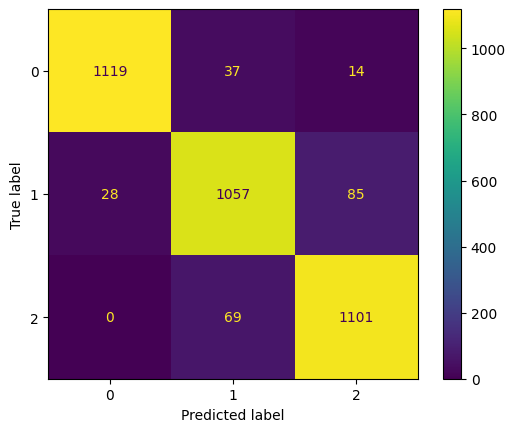

In [143]:
cm_display(Y_train_heat, heat_train_pred)

SVM

In [144]:
heat_train_pred, heat_svc = svc_with_kernel("rbf", X_trains[heat], Y_train_heat)

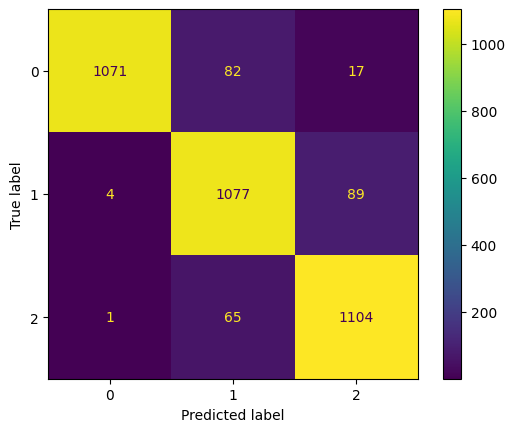

In [145]:
cm_display(Y_train_heat, heat_train_pred)

random forest

In [146]:
heat_train_pred, heat_rf = random_forest(X_trains[heat], Y_train_heat, 150, 22)

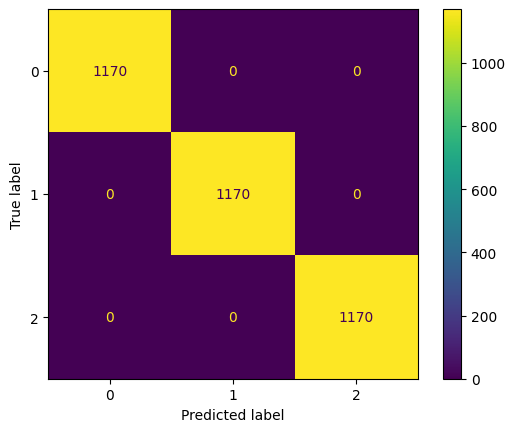

In [147]:
cm_display(Y_train_heat, heat_train_pred)

# Predict cloud cover

In [148]:
cloud = 2
Y_train_cloud = Y_trains[cloud].T[cloud]

Logistic regression

In [150]:
cloud_train_pred, cloud_logis = logistic(X_trains[cloud], Y_train_cloud)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


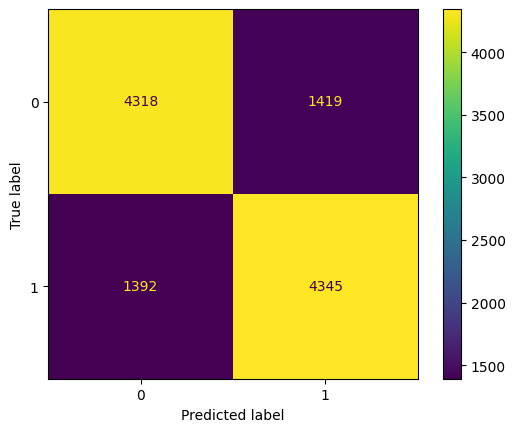

In [151]:
cm_display(Y_train_cloud, cloud_train_pred)

SVM

In [152]:
cloud_train_pred, cloud_svc = svc_with_kernel("rbf", X_trains[cloud], Y_train_cloud)

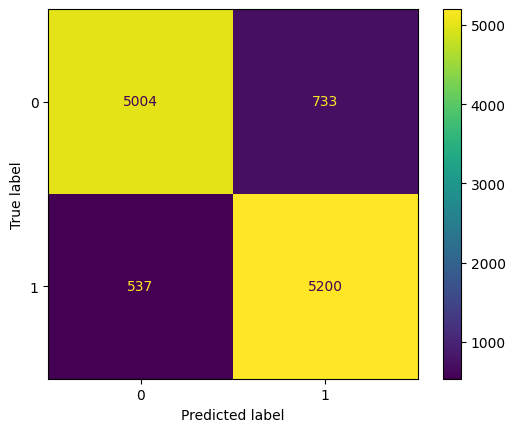

In [153]:
cm_display(Y_train_cloud, cloud_train_pred)

Random forest

In [155]:
cloud_train_pred, cloud_rf = random_forest(X_trains[cloud], Y_train_cloud, 200, 22)

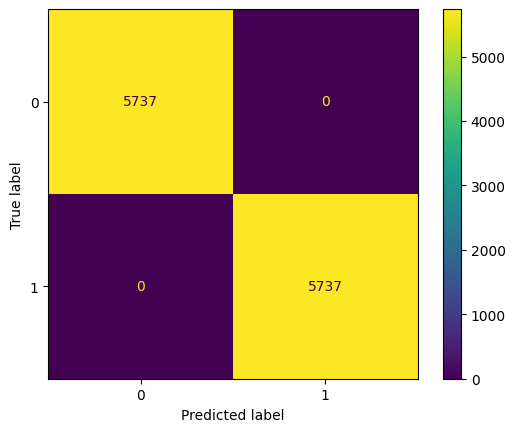

In [156]:
cm_display(Y_train_cloud, cloud_train_pred)

# Result in test set

In [105]:
def f1_score_display(Y_train, train_pred, Y_test, test_pred):
  train_f1 = f1_score(Y_train, train_pred, average="macro")
  test_f1 = f1_score(Y_test, test_pred, average="macro")
  print(train_f1)
  print(test_f1)

In [200]:
label_dict = {(0,0,0): 0, (1,0,0): 1, (1,0,1): 2, (0,0,1): 3,
              (0,1,0): 4, (1,1,0): 5, (1,1,1): 6, (0,1,1): 7,
              (0,2,0): 8, (1,2,0): 9, (1,2,1): 10, (0,2,1): 11}

In [204]:
X_test = data_pca[test_ids]
Y_test = labels[test_ids]

In [205]:
true_labels = [label_dict.get(tuple(l), -1) for l in Y_test]

Logistic regresion and softmax regresion

In [231]:
rain_test_pred = rain_logis.predict(X_test)
heat_test_pred = heat_softmax.predict(X_test)
cloud_test_pred = cloud_logis.predict(X_test)

In [232]:
ls_labels = []
for i in range(len(rain_test_pred)):
  ls_labels.append(label_dict.get(tuple([rain_test_pred[i], heat_test_pred[i], cloud_test_pred[i]])))

In [233]:
logis_f1 = f1_score(true_labels, ls_labels, average="macro")

SVM

In [234]:
rain_test_pred = rain_svc.predict(X_test)
heat_test_pred = heat_svc.predict(X_test)
cloud_test_pred = cloud_svc.predict(X_test)

In [235]:
ls_labels = []
for i in range(len(rain_test_pred)):
  ls_labels.append(label_dict.get(tuple([rain_test_pred[i], heat_test_pred[i], cloud_test_pred[i]])))

In [236]:
svm_f1 = f1_score(true_labels, ls_labels, average="macro")

Random Forest

In [237]:
rain_test_pred = rain_rf.predict(X_test)
heat_test_pred = heat_rf.predict(X_test)
cloud_test_pred = cloud_rf.predict(X_test)

In [238]:
ls_labels = []
for i in range(len(rain_test_pred)):
  ls_labels.append(label_dict.get(tuple([rain_test_pred[i], heat_test_pred[i], cloud_test_pred[i]])))

In [239]:
rf_f1 = f1_score(true_labels, ls_labels, average="macro")

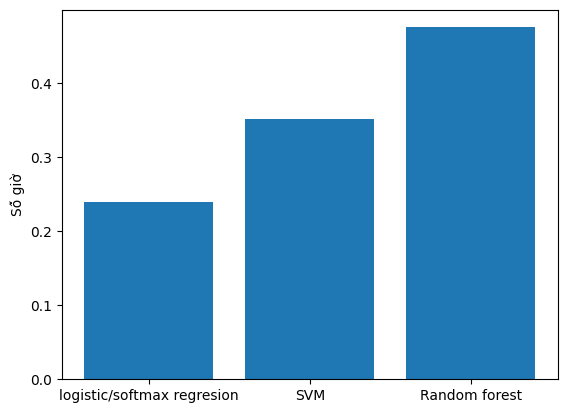

In [241]:
models = ["logistic/softmax regresion", "SVM", "Random forest"]
f1s = [logis_f1, svm_f1, rf_f1]
plt.bar(models, f1s)
plt.ylabel("Số giờ")
plt.xticks(models, models)
plt.show()

# Demo

In [ ]:
def get_weather_feats(lat, long, start_date, end_date):
	# Setup the Open-Meteo API client with cache and retry on error
  cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
  retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
  openmeteo = openmeteo_requests.Client(session = retry_session)
  hourly_feats = ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "apparent_temperature",
                  "rain", "pressure_msl", "surface_pressure", "cloud_cover", "cloud_cover_low", "cloud_cover_mid",
                  "cloud_cover_high", "wind_speed_10m", "wind_speed_100m", "wind_direction_10m", "wind_direction_100m", "wind_gusts_10m"]
  # Make sure all required weather variables are listed here
  # The order of variables in hourly or daily is important to assign them correctly below
  url = "https://archive-api.open-meteo.com/v1/archive"
  params = {
    "latitude": lat,
    "longitude": long,
    "start_date": start_date,
    "end_date": end_date,
    "hourly": hourly_feats,
    "timezone": "Asia/Bangkok"
  }

  responses = openmeteo.weather_api(url, params=params)

  # Process first location. Add a for-loop for multiple locations or weather models
  response = responses[0]
  # print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
  # print(f"Elevation {response.Elevation()} m asl")
  # print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
  # print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

  # Process hourly data. The order of variables needs to be the same as requested.
  hourly = response.Hourly()
  offset = response.UtcOffsetSeconds()
  hourly_data = {"date": pd.date_range(
    start = pd.to_datetime(hourly.Time() + offset, unit = "s"),
    end = pd.to_datetime(hourly.TimeEnd() + offset, unit = "s"),
    freq = pd.Timedelta(seconds = hourly.Interval()),
    inclusive = "left"
  )}

  for i, feat in enumerate(hourly_feats):
    hourly_data[feat] = hourly.Variables(i).ValuesAsNumpy()

  hourly_dataframe = pd.DataFrame(data = hourly_data)
  return hourly_dataframe

In [ ]:
q1_lat, q1_long = 10.7807, 106.6994
current_date = datetime.today() - relativedelta(days=2)
current_date = current_date.isoformat().split("T")[0]
print("current_date")

2023-12-23


In [ ]:
start_date = "2020-01-01"
end_date = "2023-10-31"
hourly_df = get_weather_feats(q1_lat, q1_long, start_date, end_date)
hourly_df.head(24)

,date,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,rain,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m
0,2020-01-01 00:00:00,25.789499,62.117641,17.989500,27.167923,0.0,1015.000000,1012.914551,25.500002,0.0,0.0,85.0,10.464797,20.991426,26.564985,30.963696,17.639999
1,2020-01-01 01:00:00,25.089500,64.148026,17.839500,26.513945,0.0,1014.500000,1012.410889,27.000002,0.0,0.0,90.0,9.693296,20.188908,21.801476,31.138918,14.759999
2,2020-01-01 02:00:00,24.439499,65.232491,17.489500,25.661043,0.0,1014.099976,1012.006836,26.100000,0.0,0.0,87.0,10.028439,21.120682,21.037588,29.623667,14.400000
3,2020-01-01 03:00:00,23.939499,67.643974,17.589500,25.039515,0.0,1013.599976,1011.504395,17.700001,0.0,0.0,59.0,11.165805,23.042812,20.772345,28.967560,15.840000
4,2020-01-01 04:00:00,23.589500,70.623375,17.939499,24.783075,0.0,1013.400024,1011.302673,25.500002,0.0,0.0,85.0,11.592895,23.773632,25.769283,32.005356,16.559999
5,2020-01-01 05:00:00,23.289499,72.139534,17.989500,24.505810,0.0,1013.799988,1011.699646,22.500000,0.0,0.0,75.0,11.592895,23.773632,25.769283,32.005356,16.559999
6,2020-01-01 06:00:00,22.989500,73.691109,18.039499,24.134232,0.0,1014.200012,1012.096558,23.100000,0.0,0.0,77.0,12.240000,24.766848,28.072395,32.535049,17.639999
7,2020-01-01 07:00:00,24.039499,71.374519,18.539499,25.566103,0.0,1015.299988,1013.201843,24.000000,0.0,0.0,80.0,11.183201,23.400000,33.178535,36.869991,18.000000
8,2020-01-01 08:00:00,25.839500,64.712624,18.689499,26.984768,0.0,1016.099976,1014.012634,9.000000,0.0,0.0,30.0,14.264361,19.881649,47.045418,47.935760,24.119999
9,2020-01-01 09:00:00,27.689499,58.037663,18.689499,29.050800,0.0,1016.400024,1014.325073,5.400000,0.0,0.0,18.0,12.768586,16.087610,49.574005,49.537849,25.559999


In [ ]:
hourly_df["predict_rain"] = hourly_df["rain"].apply(lambda x: 0 if x<0.3 else 1)
hourly_df["predict_cloud"] = hourly_df["cloud_cover"].apply(lambda x: 0 if x<50.0 else 1)

def heat_labeling(temp):
  if temp < 35:
    return 0
  elif temp < 37:
    return 1
  else :
    return 2
hourly_df["predict_heat"] = hourly_df["apparent_temperature"].apply(lambda x: heat_labeling(x))

In [ ]:
hourly_df.iloc[-24:, :].head(24)

,date,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,rain,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m,predict_rain,predict_cloud,predict_heat
33576,2023-10-31 00:00:00,25.989500,94.513771,25.039499,32.054298,0.0,1011.299988,1009.223816,28.500002,0.0,0.0,95.0,4.802999,2.811690,347.005371,50.194473,5.760000,0,0,0
33577,2023-10-31 01:00:00,25.589500,94.780685,24.689499,31.188499,0.0,1010.400024,1008.322815,2.700000,0.0,0.0,9.0,6.439876,3.976330,333.435028,354.805664,9.000000,0,0,0
33578,2023-10-31 02:00:00,25.139500,97.060501,24.639500,30.894451,0.0,1009.799988,1007.720886,11.400001,0.0,0.0,38.0,5.154415,5.040000,335.224884,360.000000,9.000000,0,0,0
33579,2023-10-31 03:00:00,24.939499,96.765999,24.389500,30.347561,0.0,1009.599976,1007.519958,31.500000,2.0,0.0,99.0,6.439876,7.280550,333.435028,351.469299,8.640000,0,0,0
33580,2023-10-31 04:00:00,24.739500,97.343178,24.289499,30.222321,0.0,1009.599976,1007.518433,7.500000,7.0,0.0,4.0,5.495161,9.000000,328.392548,343.739716,9.000000,0,0,0
33581,2023-10-31 05:00:00,24.489500,98.513512,24.239500,30.130272,0.0,1009.799988,1007.716492,0.900000,1.0,0.0,0.0,4.198285,7.200000,300.963684,323.130005,7.920000,0,0,0
33582,2023-10-31 06:00:00,24.489500,98.513512,24.239500,29.887886,0.0,1010.500000,1008.415039,15.599999,16.0,0.0,4.0,5.860375,10.233123,312.510406,320.710602,8.280000,0,0,0
33583,2023-10-31 07:00:00,25.339500,94.771202,24.439499,30.453529,0.0,1011.400024,1009.318848,60.899998,48.0,0.0,59.0,8.669949,8.942214,318.366547,319.899139,14.759999,0,1,0
33584,2023-10-31 08:00:00,27.439499,86.522804,24.989500,33.223083,0.0,1012.099976,1010.031921,6.000000,0.0,2.0,16.0,6.489992,8.287822,356.820221,357.510498,13.679999,0,0,0
33585,2023-10-31 09:00:00,28.739500,78.083397,24.539499,34.216759,0.0,1012.599976,1010.539795,12.600000,0.0,0.0,42.0,6.830519,8.311245,341.564941,342.349762,16.199999,0,0,0


In [ ]:
hourly_df.to_csv(data_path + "weather_data.csv", index=False)

In [ ]:
def get_last_year_week(date):
  date_list = []
  seven_days = 7*24
  deltas = [-seven_days, -1, 1, seven_days]
  date_milestone = []
  for delta in deltas:
    milestone = date + relativedelta(years= -1, hours= delta)
    date_milestone.append(str(milestone))
  return date_milestone

def get_last_week(date):
  week_far = date + relativedelta(days= -3)
  week_near = date + relativedelta(days= -9)
  return week_near, week_far

def get_week_data(data, time_near, time_far):
  pos1 = np.flatnonzero(data["date"].to_numpy() == time_near)[0]
  pos2 = np.flatnonzero(data["date"].to_numpy() == time_far)[0]
  return data.iloc[pos1:pos2+1, 1:].to_numpy(copy=True).flatten()

def build_data(date, lat, long):
  week_near, week_far = get_last_week(date)
  last_week_df = get_weather_feats(lat, long, week_near.date(), week_far.date())
  last_week_feats = last_week_df.iloc[:, 1:].to_numpy().flatten()

  ly_near_milestone = date + relativedelta(years= -1, hours= -(24*7))
  ly_far_milestone = date + relativedelta(years= -1, hours= 23 + 24*7)
  last_year_df = get_weather_feats(lat, long, ly_near_milestone.date(),
                                  ly_far_milestone.date())
  data = []
  hours = []
  last_year_df["date"] = last_year_df["date"].astype(str)
  for i in range(0, 24):
    hour = date + relativedelta(hours= i)
    ly_ms = get_last_year_week(hour)
    ly_before_feats = get_week_data(last_year_df, ly_ms[0], ly_ms[1])
    ly_after_feats = get_week_data(last_year_df, ly_ms[2], ly_ms[3])
    features = np.concatenate([last_week_feats, ly_before_feats, ly_after_feats])
    data.append(features)
    hours.append(str(hour))
  return np.array(data), hours

today = datetime.fromisoformat(str(datetime.now().date()))
today_data, hours = build_data(today, q1_lat, q1_long)

In [ ]:
test = get_weather_feats(q1_lat, q1_long, current_date, current_date)
test.head()

,date,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,rain,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m
0,2023-12-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-12-23 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-12-23 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-12-23 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-12-23 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def load_model(data_path):
  rain_sc = joblib.load(data_path + "rain_sc.joblib")
  rain_pca = joblib.load(data_path + "rain_pca.joblib")
  rain_rf = joblib.load(data_path + "rain_rf.joblib")

  heat_sc = joblib.load(data_path + "heat_sc.joblib")
  heat_pca = joblib.load(data_path + "heat_pca.joblib")
  heat_svc = joblib.load(data_path + "heat_svc.joblib")

  cloud_sc = joblib.load(data_path + "cloud_sc.joblib")
  cloud_pca = joblib.load(data_path + "cloud_pca.joblib")
  cloud_rf = joblib.load(data_path + "cloud_rf.joblib")

  return (rain_sc, rain_pca, rain_rf,
          heat_sc, heat_pca, heat_svc,
          cloud_sc, cloud_pca, cloud_rf)

In [ ]:
def weather_forecast(data_path, today_data):
  (rain_sc, rain_pca, rain_rf,
  heat_sc, heat_pca, heat_svc,
  cloud_sc, cloud_pca, cloud_rf) = load_model(data_path)

  data_scaled = rain_sc.transform(today_data)
  data_pca = rain_pca.transform(data_scaled)
  rain_pred = rain_rf.predict(data_pca)

  data_scaled = heat_sc.transform(today_data)
  data_pca = heat_pca.transform(data_scaled)
  heat_pred = heat_svc.predict(data_pca)

  data_scaled = cloud_sc.transform(today_data)
  data_pca = cloud_pca.transform(data_scaled)
  cloud_pred = cloud_rf.predict(data_pca)
  return [rain_pred, heat_pred, cloud_pred]

predict = weather_forecast(data_path, today_data)

In [ ]:
print(predict)

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int8), array([0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int8), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int8)]


In [ ]:
rain_status = ["Không mưa", "Mưa"]
heat_status = ["Mát", "Nóng", "Nóng gay gắt"]
cloud_status = ["Ít mây", "Nhiều mây"]
for i in range(0, 24):
  print(hours[i], ":")
  print(rain_status[predict[0][i]])
  print(heat_status[predict[1][i]])
  print(cloud_status[predict[2][i]])

2023-12-25 00:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 01:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 02:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 03:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 04:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 05:00:00 :
Không mưa
Nóng
Ít mây
2023-12-25 06:00:00 :
Không mưa
Nóng
Ít mây
2023-12-25 07:00:00 :
Không mưa
Nóng
Ít mây
2023-12-25 08:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 09:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 10:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 11:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 12:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 13:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 14:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 15:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 16:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 17:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 18:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 19:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 20:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 21:00:00 :
Không mưa
Mát
Ít mây
2023-12